# SSP Scenario Bias Corrections - Python Workflow

### About: 
This notebook is a secondary path for creating bias-corrected ssp scenarios using OISST and SODA reanalysis data. This workflow avoids hopping across programming languages and makes it easier to preserve a consistent netcdf file convention. It also performs the bias correction for all variables, not just temp. (thats the goal atleast).

Currently this is not a high priority workflow, but would be recommended if asked to repeat or start over.

### Status: Incomplete

Challenge here is to repeat the bias correction process for each of the SSP scenario datasets and for each variable. Currently this is managed in R by a repeating functions on a list of datasets, so a similar path would be to emulate that here in this notebook with lists.

In [8]:
# Libraries
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os


# Set the workspace - local/ docker
cmip_root  = "/Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6"

# Path to the scenarios
ssp1_path = f"{cmip_root}/SSP1_26/"
ssp5_path = f"{cmip_root}/SSP5_85/"

# Path to the obervation and reanalysis data itself
soda_root  = "/Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/SODA"
oisst_root = "/Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/OISST/oisst_mainstays"

# Path to Observation Data Climatologies - bias correct with
soda_clim_path = f"{soda_root}SODA_monthly_climatology1985to2014.nc"
sst_clim_path = f"{oisst_root}/daily_climatologies/daily_clims_1985to2014.nc"


## Why Do this Again?

The R workflow performs as expected, why repeat?

The main issue with the workflow as-is, is the structural integrity of the grid appears to be degrading as we go from netcdf and xarray to R and raster/terra. This is not a determination that this cannot be fixed. More specifically, saving from R to netcdf seems to be performing in an undesirable way, which is creating a strange NA pattern when loaded back into python, a one-way data pipeline.

#### What does that look like?

Here is how an SSP scenario's model run looks prior to entering the R-based workflow:

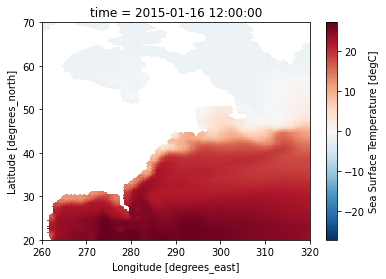

In [12]:
# SSP5 Raw
ssp5_raw_stemp = xr.open_dataset(f"{ssp5_path}SST/StGrid/stGrid_tos_CanESM5-CanOE_r1i1p2f1_ssp585.nc")
ssp5_raw_stemp.isel(time = 0).tos.plot()

### Here is How Netcdfs from R appear:

This looks fine actually, maybe its an xarray indexing thing...

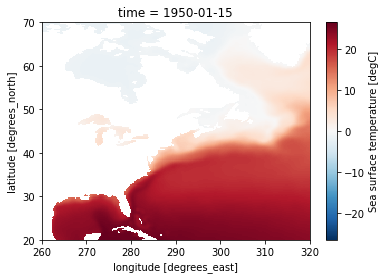

In [9]:
# SSP5 Bias Corrected
ssp5_stemp = xr.open_dataset(f"{ssp5_path}BiasCorrected/EnsembleData/surf_temp/surf_temp_OISST_bias_corrected_mean.nc")
ssp5_stemp.isel(time = 0).sst.plot()

# Performing all Maipulations in Python

The following codes will perform the ETL steps necessary for bias corrections for CMIP6 SSP scenario model runs.

In [ ]:
# Load SODA Bottom Temperature
soda_btemp = xr.open_dataset(f"{soda_root}/SODA_Temp_Red_bottomLayer.nc")
soda_btemp = soda_btemp.rename_vars({"temp" : "bot_temp"}).drop("st_ocean")

# Load SODA Bottom Salinity
soda_bsalt = xr.open_dataset(f"{soda_root}/SODA_Salt_Red_bottomLayer.nc")
soda_bsalt = soda_bsalt.rename_vars({"salt" : "bot_sal"}).drop("st_ocean")

# Load SODA Salinity
soda_salt = xr.open_dataset(f"{soda_root}/SODA_Salt_Red.nc")
soda_salt = soda_salt.rename_vars({"salt" : "surf_sal"}).drop("st_ocean")


### Dropping Depth Dimension from SODA

Soda reanalysis contains data at different depths. In a different python script the surface and bottom measurements have been skimmed off, but for data organization sake it can be easier to remove this dimension entirely and just work with lat/lon/time. The following function removes this dimension to make that easier.

In [ ]:
# Drop the depth dimension where it exists, then rebuild.
# Takes the first layer for depth to grab surface measurements in the case of SST and bottom in the case where there


def remove_st_ocean(xr_ds, var):
    """Pull out data as an array, drop st_ocean dimension, rebuild xr.array. 
    Need to pull surface measurement from surface data arrays so depth coordinate
    becomes unnecessary.
    
    Args:
        xr_ds      : xr.ArrayDataset
        var (str)  : String indicating variable to pull and process
    
    """
    
    # Take the data values out as an array
    data = xr_ds[var].values 
    
    # Take all values from each dimension EXCEPT depth
    if var in ["surf_temp", "surf_sal"]:
        data = data[:, 0, :, :] 
    
    # Pull the coordinates
    time     = xr_ds.coords['time']
    xt_ocean = xr_ds.coords['xt_ocean']
    yt_ocean = xr_ds.coords['yt_ocean']

    # Building an xr.array
    xr_manual = xr.DataArray(data, coords = [time, yt_ocean, xt_ocean])
    return xr_manual

### Removing Depth and Renaming Variables

This next cell just performs function above and renames the variables accordingly.



In [ ]:
# Drop depth, rename variable, reconstruct array
soda_btemp = remove_st_ocean(xr_ds = soda_btemp, var = "bot_temp")
soda_bsalt = remove_st_ocean(xr_ds = soda_bsalt, var = "bot_sal")
soda_salt = remove_st_ocean(xr_ds = soda_salt, var = "surf_sal")

# Put them all together as one thing
soda_full = xr.Dataset({
    "surf_sal"  : soda_salt,
    "bot_temp"  : soda_btemp,
    "bot_sal"   : soda_bsalt})

# Inspect it
soda_full 

### Load OISST

In [ ]:
# Load the annual files for oisst:
oisst_location  = f"{oisst_root}/annual_observations/"
base_fname      = "sst.day.mean."
file_ending     = ".v2.nc"


# Make a list to hold file names
fpaths = []
for yr in range(yr_min, yr_max + 1):
    fpaths.append(f'{oisst_location}{base_fname}{yr}{file_ending}')
    
# Lazy-load using xr.open_mfdataset
sst = xr.open_mfdataset(fpaths, combine = "by_coords", parallel = True)

# Resample to monthly
oisst = sst.resample(time="1MS").mean(dim="time")
oisst.isel(time = 0).sst.plot()

# Perform Bias Corrections